# Flash Crash Prediction via VPIN

In [1]:
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## 1. Read Volume Bar Data

In [2]:
from utils import read_bars as read_bars_tmp

def read_bars(csv_file: str)->pd.DataFrame:
    # Flash crash time range
    TIME_BEGIN = pd.to_datetime('2020-05-10T00:00:00.000Z')
    TIME_END = pd.to_datetime('2020-05-10T00:22:00.000Z')
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [3]:
# Bars are built by ../bars/standard-bars.ipynb
volume_bars = read_bars('/data/bars/VolumeBar/2048/VolumeBar.2048.Binance.Swap.BTC_USDT.csv').reset_index(drop=True)

In [4]:
volume_bars.head()

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,median,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy
0,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:00:45.697,2020-05-10 00:04:01.412,9562.980469,9580.000000,9527.870117,...,9553.099609,2046.099,849.094,1197.005,19548276.0,8118874.0,19547426.0,3394,1573,1821
1,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:04:01.412,2020-05-10 00:04:16.701,9527.820312,9529.629883,9500.410156,...,9512.040039,2051.061,511.617,1539.444,19511484.0,4867346.0,19510972.0,2313,904,1409
2,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:04:16.701,2020-05-10 00:04:36.602,9509.280273,9521.339844,9469.400391,...,9500.464844,2047.125,553.092,1494.033,19440464.0,5258803.5,19439912.0,1908,739,1169
3,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:04:36.602,2020-05-10 00:05:16.161,9469.150391,9505.110352,9465.000000,...,9489.564453,2028.686,744.903,1283.783,19237554.0,7067743.5,19236808.0,2840,1288,1552
4,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:05:16.161,2020-05-10 00:06:25.973,9465.000000,9524.099609,9455.000000,...,9485.240234,2068.850,1185.376,883.474,19620724.0,11252063.0,19619538.0,3677,2152,1525


## 2. Plot Price and VPIN

In [5]:
def calc_vpin(bars: pd.DataFrame)->None:
    vpin = bars['vpin'] = (bars['volume_sell'] - bars['volume_buy']).abs() / bars['volume']
    bars['vpin'] = vpin
    bars['cdf'] = vpin.rank(pct=True)

In [6]:
calc_vpin(volume_bars)

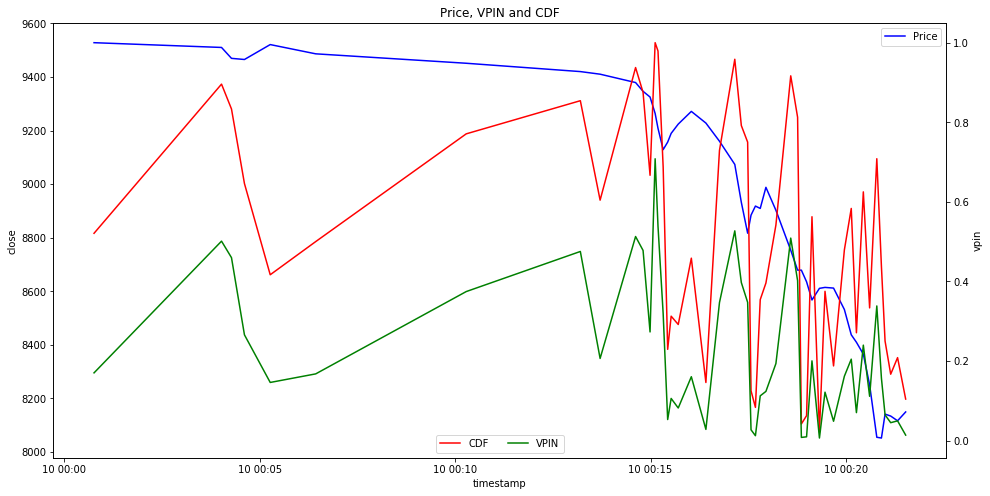

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x=volume_bars['timestamp'], y=volume_bars['close'], ax=ax, color='blue', label='Price').set_title('Price, VPIN and CDF')
ax2 = plt.twinx()
sns.lineplot(x=volume_bars['timestamp'], y=volume_bars['cdf'], ax=ax2, color='red', label='CDF')
sns.lineplot(x=volume_bars['timestamp'], y=volume_bars['vpin'], ax=ax2, color='green', label='VPIN')
plt.legend(loc=8, ncol=5)

## 3. Flash Crash Prediction

We predict there will be flash crash when CDF > 0.95.

In [8]:
flash_crashes = volume_bars[volume_bars['cdf']>0.95]

In [9]:
flash_crashes

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy,vpin,cdf
12,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:15:07.040,2020-05-10 00:15:11.421,9320.950195,9322.490234,9261.459961,...,298.919,1749.8790,19035160.0,2777635.0,19034862.0,1480,442,1038,0.708201,1.000000
13,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:15:11.421,2020-05-10 00:15:19.355,9263.690430,9271.959961,9202.860352,...,471.832,1575.5391,18912526.0,4361268.5,18912054.0,1942,824,1118,0.539085,0.979167
21,Binance,Swap,BTC_USDT,VolumeBar,2048,2020-05-10 00:17:09.311,2020-05-10 00:17:19.352,9160.000000,9161.080078,9066.099609,...,497.601,1606.3660,19176180.0,4533335.0,19175682.0,2427,977,1450,0.526988,0.958333


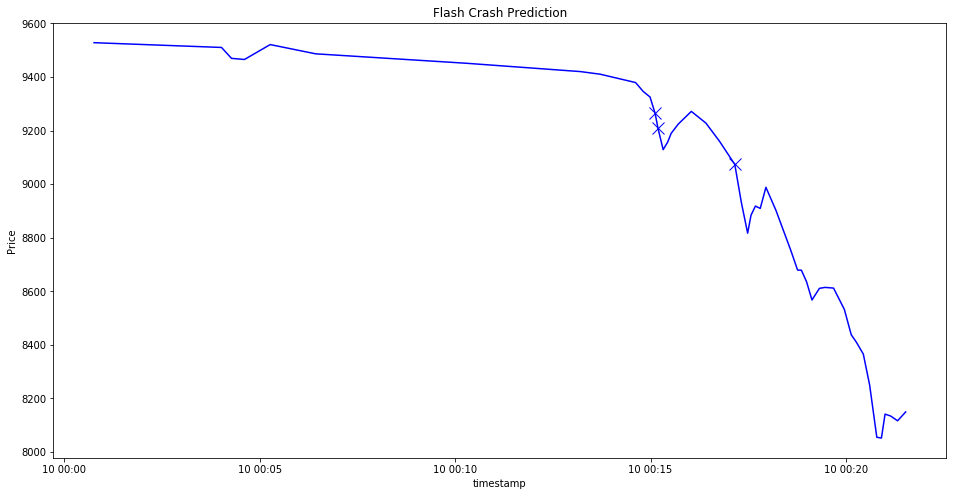

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title('Flash Crash Prediction')
ax.set_xlabel('timestamp')
ax.set_ylabel('Price')
plt.plot(volume_bars['timestamp'], volume_bars['close'], marker="x", ms=12, markevery=flash_crashes.index.to_list(), color='blue')
plt.show()

## References

* [Order Flow Toxicity of the Bitcoin April Crash](http://jheusser.github.io/2013/10/13/informed-trading.html)
* [火量学派5】VPIN 在高波动市场中的应用](http://research.huobi.com/detail/259)
* <https://github.com/jedi92/VPIN_HFT>